# Clustering Yelp Restaurants

**To be completed INDIVIDUALLY and due on Febrary 17 at 7pm.**

In this assignment, we will be working with the [Yelp dataset](https://www.yelp.com/dataset/challenge). Download the data from Round 11. You can find the format of the dataset [here](https://www.yelp.com/dataset/documentation/json).

a) From the Business Objects, let's try to find culinary districts in **Las Vegas**. These are characterized by closeness and similarity of restaurants. Use the "longitude" and "latitude" to cluster closeness. Use "categories" to cluster for similarity. You are going to use the following popular categories: 'Mexican', 'Fast Food', 'Pizza', 'American (Traditional)', 'Sandwitches', 'Breakfast & Brunch', 'Chinese', 'Italian'.

Note that the spatial coordinates and restaurant categories have different units of scale. Your results could be arbitrarily skewed if you don't incorporate some scaling. For this purpose, you need to scale the latitude and longitude at a range from [1,5].

Find clusters using the 3 different techniques we discussed in class: k-means++, hierarchical, and GMM. **(3 pts)**

In [1]:
import json
import pandas as pd
from sklearn import preprocessing
import numpy as np

np.set_printoptions(threshold=np.nan)

business = []
popcats = ['Mexican', 'Fast Food', 'Pizza', 'American (Traditional)', 'Sandwitches', 'Breakfast & Brunch', 'Chinese', 'Italian']
with open('business.json') as f:
    for line in f:
        tmp = json.loads(line)
        if tmp['city']=='Las Vegas':
            if 'Restaurants' in tmp['categories']:
                tmpcat = []
                
                for item in tmp['categories']:
                    for item2 in popcats:
                        if (item == item2):
                            tmpcat.append(item)
                if tmpcat:
                    business.append([tmp['latitude'], tmp['longitude'], tmpcat])
labels = ['lat', 'long', 'cats']
df = pd.DataFrame(business, columns = labels)
#print(business)
print(df)

min_max_scaler = preprocessing.MinMaxScaler()

lat_minmax = min_max_scaler.fit_transform(df.loc[:, 'lat'].values.reshape(-1,1))
long_minmax = min_max_scaler.fit_transform(df.loc[:, 'long'].values.reshape(-1,1))

latoneto5list = []
longoneto5list = []
for index in range(len(lat_minmax)):
    temp1 = (((lat_minmax[index] - lat_minmax.min()) * (5 - 1)) / (lat_minmax.max() - lat_minmax.min())) + 1
    temp2 = (((long_minmax[index] - long_minmax.min()) * (5 - 1)) / (long_minmax.max() - long_minmax.min())) + 1
    latoneto5list.append(temp1)
    longoneto5list.append(temp2)
    
latoneto5 = np.array(latoneto5list)
longoneto5 = np.array(longoneto5list)

df.loc[:,'lat'] = latoneto5
df.loc[:,'long'] = longoneto5
print(df)

            lat        long                                               cats
0     36.064652 -115.118954                                        [Fast Food]
1     36.111057 -115.241688                                          [Italian]
2     36.130013 -115.109310                                        [Fast Food]
3     36.112895 -115.062353                                        [Fast Food]
4     36.034244 -115.171409                           [American (Traditional)]
5     36.010086 -115.118656                                   [Italian, Pizza]
6     36.098632 -115.136079                                          [Mexican]
7     36.271838 -115.263279                           [American (Traditional)]
8     36.140925 -115.142887       [American (Traditional), Breakfast & Brunch]
9     36.238059 -115.210341                                            [Pizza]
10    36.159483 -115.287451                                          [Mexican]
11    36.122084 -115.168032                         

In [2]:
#vectorize
list1 = df.loc[:,'cats']
print (list1.values)
final = []
for item in list1:
    stringbuilder = ''
    if (len(item) > 1):
        for item2 in item:
            stringbuilder += item2 + " "
    else:
        stringbuilder=str(item[0])
    final.append(stringbuilder)
    
print(final)

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
mtx = vectorizer.fit_transform(final)
print(vectorizer.get_feature_names())
mtx = (mtx.toarray())

finalM = mtx.tolist()
counter = 0

print(finalM)
for item in finalM:
    item.append(float(latoneto5[counter]))
    item.append(float(longoneto5[counter]))
    counter+=1

print(finalM)

[['Fast Food'] ['Italian'] ['Fast Food'] ['Fast Food']
 ['American (Traditional)'] ['Italian', 'Pizza'] ['Mexican']
 ['American (Traditional)']
 ['American (Traditional)', 'Breakfast & Brunch'] ['Pizza'] ['Mexican']
 ['Fast Food', 'Chinese'] ['Mexican'] ['Breakfast & Brunch'] ['Fast Food']
 ['Fast Food'] ['Pizza'] ['American (Traditional)'] ['Pizza'] ['Fast Food']
 ['Fast Food', 'American (Traditional)'] ['Mexican']
 ['Fast Food', 'Mexican'] ['Breakfast & Brunch'] ['Mexican'] ['Fast Food']
 ['American (Traditional)'] ['Pizza'] ['Chinese', 'Fast Food'] ['Pizza']
 ['Mexican'] ['Fast Food', 'American (Traditional)'] ['Mexican']
 ['Pizza', 'Italian'] ['Breakfast & Brunch'] ['Fast Food'] ['Mexican']
 ['Fast Food'] ['Chinese'] ['Mexican'] ['Mexican'] ['Pizza'] ['Mexican']
 ['Mexican'] ['Fast Food'] ['Mexican'] ['Pizza'] ['American (Traditional)']
 ['Pizza'] ['Fast Food'] ['Pizza'] ['Fast Food'] ['Mexican'] ['Chinese']
 ['American (Traditional)'] ['Fast Food'] ['Breakfast & Brunch']
 ['Americ

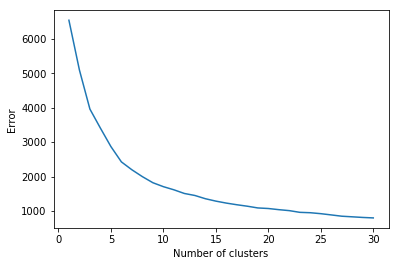

In [3]:
#Kmeans
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

def evaluate_clusters(X,max_clusters):
    error = np.zeros(max_clusters+1)
    error[0] = 0;
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        error[k] = kmeans.inertia_

    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Error')

evaluate_clusters(finalM, 30) #maybe 7 clusters

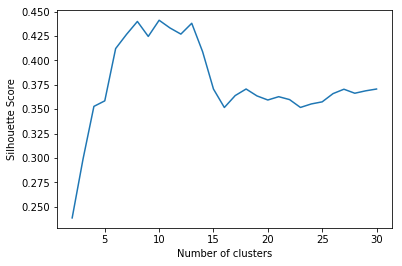

In [8]:
#Hierarchal

import scipy.cluster
import scipy.cluster.hierarchy as hierarchy
import scipy.spatial.distance
import sklearn.metrics as metrics
%matplotlib inline

Z_20ng = hierarchy.linkage(finalM, method='ward', metric='euclidean')

max_clusters = 30
s = np.zeros(max_clusters+1)
for k in range(2,max_clusters+1):
    clusters = hierarchy.fcluster(Z_20ng, k, criterion='maxclust')
    s[k] = metrics.silhouette_score(finalM,clusters,metric='euclidean')
plt.plot(range(2,len(s)),s[2:])
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

In [37]:
#GMM 
from sklearn import mixture

finalM2 = finalM

gmm = mixture.GaussianMixture(n_components=7, covariance_type='full')

gmm.fit(finalM2)

y_pred = gmm.predict(finalM2)

In [38]:
#final K means
kmeans = KMeans(init='k-means++', n_clusters=7, n_init=10)
kmeans.fit_predict(finalM)
labels = kmeans.labels_

#final hierarchal
Z_20ng = hierarchy.linkage(finalM, method='ward', metric='euclidean')
clusters = hierarchy.fcluster(Z_20ng, 7, criterion='maxclust')

b) Explain your data representation and how you determined certain parameters (for example, the number of clusters for each method). **(1 pt)**

c) Visualize the clusters by plotting the longitude/latitude of the restaurants in a scatter plot. Label each cluster with a category. In a markdown, explain how labels are assigned. **(2 pts)**

Note that some categories are inherently more common (e.g. "pizza"). When labeling your clusters, you want to avoid the scenario where all clusters are labeled as "pizza" simply because of the uniformly large number of these restaurants across all clusters. In other words, we don’t want to point out that pizza restaurants are pretty much evenly distributed in high quantities everywhere, but rather discover when they, or another type of restaurant, appear in notably high quantities.

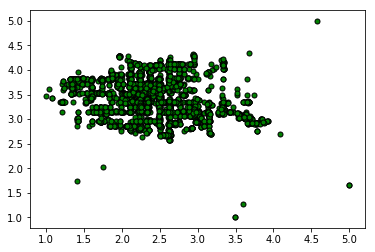

In [74]:
plt.scatter(latoneto5, longoneto5, marker='o', c='g',
            s=25, edgecolor='k')

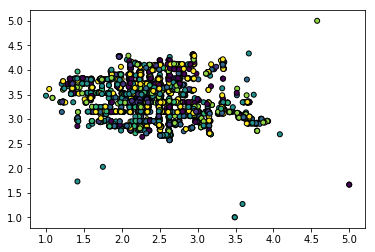

In [73]:
finalN = np.asarray(finalM)

#print(finalN)
#print(finalN[:,10])
#print(finalN[:,11])

plt.scatter(finalN[:,10], finalN[:,11], marker='o', c=labels,s=25, edgecolor='k')

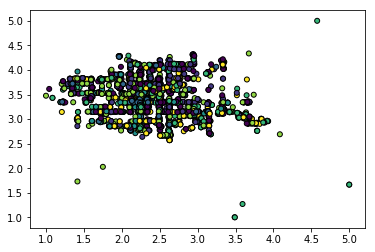

In [42]:
#print(clusters)

plt.scatter(finalN[:,10], finalN[:,11], marker='o', c=clusters,s=25, edgecolor='k')

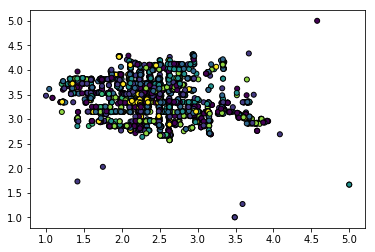

In [44]:
plt.scatter(finalN[:,10], finalN[:,11], marker='o', c=y_pred,s=25, edgecolor='k')

d) Now let's detect outliers. These are the points that are the farthest from the centroids of their clusters. In order to find the outliers, you need to find the distances of all cluster points from the centroid and select the ones whose distance is above the 85th percentile. **(3 pts)**

In [125]:
import sklearn.metrics as metrics
from scipy.spatial import distance


errorlist = [[],[],[],[],[],[],[]]
centroids = kmeans.cluster_centers_
#distance = metrics.pairwise.euclidean_distances(finalN[0], centroids[labels[0]])

counter = 0

absoluteError = []

for index in range(len(labels)):
    change = distance.euclidean(finalN[index], centroids[labels[index]])
    errorlist[labels[index]].append((change))
    absoluteError.append(change)

percentileRange = []
for index in errorlist:
    percentileRange.append(np.percentile(index,95))

print(percentileRange)
#print(errorlist)

#print((errorlist[0]))

outliers = [[],[],[],[],[],[],[]]
    
for index in range(len(percentileRange)):
    for index2 in ((errorlist[index])):
        if (percentileRange[index] < index2):
            outliers[index].append((index2))
            
#print(outliers)
outliercount = 0

for index in range(len(outliers)):
    print("for cluster " + str(index) + ": ")
    for point in outliers[index]:
        for index2 in range(len(absoluteError)):
            if (point == absoluteError[index2]) & (labels[index2] == index):
                print(finalN[index2])
                outliercount+=1
                
print(outliercount)

[1.1548866333308625, 1.060050665706697, 1.5340234669787012, 1.5028654064294757, 1.1945033392735738, 1.2379408702209775, 1.4285929923033467]
for cluster 0: 
[ 0.          0.          0.          0.          0.          0.          0.
  1.          0.          0.          3.55204951  3.07174008]
[ 0.          0.          0.          0.          0.          0.          0.
  1.          0.          0.          1.31333283  3.823127  ]
[ 0.          0.          0.          0.          0.          0.          1.
  1.          0.          0.          1.98614573  3.90677423]
[ 0.          0.          0.          0.          0.          0.          0.
  1.          0.          0.          3.83618496  3.0038235 ]
[ 0.          0.          0.          0.          0.          0.          0.
  1.          0.          0.          3.6413768   3.34347268]
[ 0.          0.          0.          0.          0.          0.          0.
  1.          0.          0.          3.69654714  2.91400543]
[ 0.      

[ 1.          1.          1.          0.          0.          0.          0.
  1.          0.          1.          3.60608759  3.0362014 ]
for cluster 3: 
[ 1.          0.          0.          0.          1.          1.          0.
  0.          0.          1.          1.48362668  3.81949483]
[ 1.          0.          0.          0.          0.          0.          1.
  0.          1.          1.          3.11732362  3.1517753 ]
[ 1.          0.          0.          0.          1.          1.          0.
  0.          0.          1.          3.41457646  3.15121375]
[ 1.          0.          0.          0.          1.          1.          0.
  0.          0.          1.          3.1523618   2.94515408]
[ 1.          0.          0.          0.          0.          0.          0.
  0.          0.          1.          3.91755927  2.96755369]
[ 1.          0.          0.          0.          0.          0.          1.
  1.          0.          1.          2.3965182   3.99407288]
[ 1.       

[ 0.          0.          0.          0.          0.          0.          0.
  0.          1.          0.          3.78490322  2.91466401]
[ 0.          0.          0.          0.          0.          0.          0.
  0.          1.          0.          3.88270168  2.94046754]
[ 0.          0.          0.          0.          0.          0.          0.
  0.          1.          0.          3.66807602  2.91457249]
[ 0.          0.          0.          0.          0.          0.          0.
  0.          1.          0.          3.93073082  2.95748186]
[ 0.          0.          0.          0.          0.          0.          0.
  0.          1.          0.          3.83642821  3.00479942]
[ 0.          0.          0.          0.          0.          0.          0.
  0.          1.          0.          3.7167564   3.00487691]
[ 0.          0.          0.          0.          0.          0.          0.
  0.          1.          0.          3.86990352  2.93866952]
[ 0.          0.          0

e) Give an analysis comparing the results you obtained from the 3 techniques. **(1 pts)**

----------